In [1]:
from typing import List, Optional, Iterable, Dict, Any
from itertools import islice
from functools import lru_cache, partial
from dataclasses import dataclass

import pandas as pd
from pandas.tseries.frequencies import to_offset
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import tqdm.auto as tqdm
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from datasets import load_dataset, interleave_datasets
from datasets.iterable_dataset import RandomlyCyclingMultiSourcesExamplesIterable


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import einsum
from torch.utils.data import DataLoader


from einops import rearrange, repeat
from vector_quantize_pytorch import VectorQuantize

from gluonts.core.component import validated
from gluonts.dataset.common import Dataset, ListDataset, DatasetCollection, ProcessDataEntry
from gluonts.dataset.field_names import FieldName
from gluonts.itertools import Cyclic, PseudoShuffled, IterableSlice
from gluonts.torch.modules.loss import DistributionLoss, NegativeLogLikelihood
from gluonts.transform import (
    Transformation,
    Chain,
    RemoveFields,
    SetField,
    AsNumpyArray,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AddAgeFeature,
    VstackFeatures,
    InstanceSplitter,
    ValidationSplitSampler,
    TestSplitSampler,
    ExpectedNumInstanceSampler,
    SelectFields,
    InstanceSampler,
)
from gluonts.torch.util import (
    IterableDataset,
)
from gluonts.time_feature import (
    TimeFeature,
    time_features_from_frequency_str,
)
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.evaluation._base import aggregate_valid
from gluonts.torch.model.estimator import PyTorchLightningEstimator
from gluonts.torch.model.predictor import PyTorchPredictor
from gluonts.torch.distributions import (
    DistributionOutput,
    StudentTOutput,
)
from gluonts.torch.util import weighted_average
from gluonts.torch.modules.scaler import MeanScaler, NOPScaler
from gluonts.torch.modules.feature import FeatureEmbedder
from gluonts.time_feature import get_lags_for_frequency
from gluonts.dataset.repository.datasets import get_dataset

In [2]:
def FeedForward(dim, hidden_dim, dropout=0.0):
    return nn.Sequential(
        nn.LayerNorm(dim),
        nn.Linear(dim, hidden_dim, bias=False),
        nn.GELU(),
        nn.Dropout(dropout),
        nn.Linear(hidden_dim, dim, bias=False),
    )

In [3]:
class Attention(nn.Module):
    def __init__(
        self,
        dim,
        dim_head=64,
        heads=8,
        dropout=0.
    ):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        inner_dim = heads * dim_head

        self.norm = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(dropout)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)
        self.to_out = nn.Linear(inner_dim, dim, bias = False)

    def forward(self, x):
        x = self.norm(x)

        q, k, v = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), (q, k, v))

        q = q * self.scale

        sim = einsum('b h i d, b h j d -> b h i j', q, k)

        attn = sim.softmax(dim = -1)
        attn = self.dropout(attn)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)

        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

In [49]:
class VQAttention(nn.Module):
    def __init__(
        self,
        dim,
        codebook_size,
        dim_feedforward=16,
        dim_head=16,
        heads=2,
        max_heads_process=2,
        dropout=0.0,
        cross_attn_dropout=0.0,
        depth=1,
        decay=0.8,
        commitment_weight=1.,
    ):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        self.max_heads_process = max_heads_process

        inner_dim = heads * dim_head
        self.dim = dim

        self.norm = nn.LayerNorm(dim)
        self.context_norm = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(dropout)
        
        # they drop out a percentage of the prefix during training, shown to help prevent overfitting
        self.cross_attn_dropout = cross_attn_dropout  

        self.to_q = nn.Linear(dim, inner_dim, bias=False)
        self.to_kv = nn.Linear(dim, inner_dim * 2, bias=False)
        self.to_out = nn.Linear(inner_dim, dim)
        
        self.vq = VectorQuantize(
            dim=dim,
            codebook_size=codebook_size,
            decay=decay,
            commitment_weight=commitment_weight,
            threshold_ema_dead_code=2,
        )
        
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim=dim, dim_head=dim_head, heads=heads, dropout=dropout),
                FeedForward(dim, hidden_dim=dim_feedforward, dropout=dropout),
            ]))

    def forward(self, context_input, context_mask=None):
        batch, context_len, device = context_input.shape[0], context_input.shape[-2], context_input.device

        # take care of cross attention dropout
        if self.training and self.cross_attn_dropout > 0.0:
            rand = torch.zeros((batch, context_len), device=device).uniform_()
            keep_context_len = context_len - int(context_len * self.cross_attn_dropout)
            keep_indices = rand.topk(keep_context_len, dim=-1).indices
            keep_mask = torch.zeros_like(rand).scatter_(1, keep_indices, 1).bool()

            context_input = rearrange(context_input[keep_mask], "(b n) d -> b n d", b=batch)

            if context_mask is not None:
                context_mask = rearrange(
                    context_mask[keep_mask], "(b n) -> b n", b=batch
                )

        _, indices, commit_loss, perplexity = self.vq(context_input)
      
        x = repeat(self.vq.codebook, 'm d -> b m d', b=batch) #[B, M, D]
        
        # normalization
        x = self.norm(x)
        context = self.context_norm(context_input)

        # derive queries, keys, values
        q = self.to_q(x)
        k, v = self.to_kv(context).chunk(2, dim=-1)

        q, k, v = map(
            lambda t: rearrange(t, "b n (h d) -> b h n d", h=self.heads), (q, k, v)
        )
        q = q * self.scale

        # take care of masking
        i, j = q.shape[-2], k.shape[-2]
        mask_value = -torch.finfo(q.dtype).max

        if context_mask is not None:
            mask_len = context_mask.shape[-1]
            context_mask = F.pad(context_mask, (0, max(j - mask_len, 0)), value=True)
            context_mask = rearrange(context_mask, "b j -> b 1 1 j")

        # process in chunks of heads
        out = []
        max_heads = self.max_heads_process
        for q_chunk, k_chunk, v_chunk in zip(
            q.split(max_heads, dim=1),
            k.split(max_heads, dim=1),
            v.split(max_heads, dim=1),
        ):
            sim = einsum("b h i d, b h j d -> b h i j", q_chunk, k_chunk)

            if context_mask is not None:
                sim = sim.masked_fill(~context_mask, mask_value)

            attn = sim.softmax(dim=-1)
            attn = self.dropout(attn)

            out_chunk = einsum("b h i j, b h j d -> b h i d", attn, v_chunk)
            out.append(out_chunk)

        # concat all the heads together
        out = torch.cat(out, dim=1)

        # merge heads and then combine with linear
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.to_out(out)
        
        # self-attention on latents
        for attn, ff in self.layers:
            out = attn(out) + out
            out = ff(out) + out

        expanded_indices = indices.unsqueeze(-1).expand(*indices.shape, self.dim)
        outputs = torch.gather(out, 1, expanded_indices)
        
        return outputs, commit_loss, perplexity

In [50]:
class VQTrModel(nn.Module):
    @validated()
    def __init__(
        self,
        context_length: int,
        prediction_length: int,
        num_feat_dynamic_real: int,
        num_feat_static_real: int,
        num_feat_static_cat: int,
        cardinality: List[int],
        
        # VQ arguments
        codebook_size: int,
        decay: float,
        commitment_weight: float,

        # transformer arguments
        nhead: int,
        depth: int,
        dim_head: int,
        num_encoder_layers: int,
        num_decoder_layers: int,
        dim_feedforward: int,
        activation: str = "gelu",
        dropout: float = 0.1,

        # univariate input
        input_size: int = 1,
        embedding_dimension: Optional[List[int]] = None,
        distr_output: DistributionOutput = StudentTOutput(),
        freq: Optional[str] = None,
        lags_seq: Optional[List[int]] = None,
        scaling: bool = True,
        num_parallel_samples: int = 100,
    ) -> None:
        super().__init__()
        
        assert (freq is not None) or (lags_seq is not None), "either freq or lags_seq must be given"
        
        self.input_size = input_size
       
        self.target_shape = distr_output.event_shape
        self.num_feat_dynamic_real = num_feat_dynamic_real
        self.num_feat_static_cat = num_feat_static_cat
        self.num_feat_static_real = num_feat_static_real
        self.embedding_dimension = (
            embedding_dimension
            if embedding_dimension is not None or cardinality is None
            else [min(50, (cat + 1) // 2) for cat in cardinality]
        )
        
        
        self.lags_seq = lags_seq or get_lags_for_frequency(freq_str=freq)
        
        self.num_parallel_samples = num_parallel_samples
        self.history_length = context_length + max(self.lags_seq)
        self.embedder = FeatureEmbedder(
            cardinalities=cardinality,
            embedding_dims=self.embedding_dimension,
        )
        if scaling:
            self.scaler = MeanScaler(dim=1, keepdim=True)
        else:
            self.scaler = NOPScaler(dim=1, keepdim=True)
        
        # total feature size
        d_model = self.input_size * len(self.lags_seq) + self._number_of_features
        
        self.context_length = context_length
        self.prediction_length = prediction_length
        self.distr_output = distr_output
        self.param_proj = distr_output.get_args_proj(d_model)
            
        # transformer enc-decoder and mask initializer        
        self.encoder = nn.ModuleList([])
        for _ in range(num_encoder_layers):
            self.encoder.append(
                VQAttention(
                    codebook_size=codebook_size,
                    decay=decay,
                    commitment_weight=commitment_weight,
                    dim=d_model,
                    depth=depth,
                    heads=nhead,
                    dim_head=dim_head,
                    dim_feedforward=dim_feedforward,
                    dropout=dropout,
                    cross_attn_dropout=dropout,
                ), 
            )
        
        decoder_norm = nn.LayerNorm(d_model, eps=1e-5)
        decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout, activation, 
                                                layer_norm_eps=1e-5, 
                                                batch_first=True, 
                                                norm_first=False)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_decoder_layers, decoder_norm)
            
        # causal decoder tgt mask
        self.register_buffer(
            "tgt_mask",
            nn.Transformer.generate_square_subsequent_mask(prediction_length),
        )
        
    @property
    def _number_of_features(self) -> int:
        return (
            sum(self.embedding_dimension)
            + self.num_feat_dynamic_real
            + self.num_feat_static_real
            + 1  # the log(scale)
        )

    @property
    def _past_length(self) -> int:
        return self.context_length + max(self.lags_seq)
    
    def get_lagged_subsequences(
        self,
        sequence: torch.Tensor,
        subsequences_length: int,
        shift: int = 0
    ) -> torch.Tensor:
        """
        Returns lagged subsequences of a given sequence.
        Parameters
        ----------
        sequence : Tensor
            the sequence from which lagged subsequences should be extracted.
            Shape: (N, T, C).
        subsequences_length : int
            length of the subsequences to be extracted.
        shift: int
            shift the lags by this amount back.
        Returns
        --------
        lagged : Tensor
            a tensor of shape (N, S, C, I), where S = subsequences_length and
            I = len(indices), containing lagged subsequences. Specifically,
            lagged[i, j, :, k] = sequence[i, -indices[k]-S+j, :].
        """
        sequence_length = sequence.shape[1]
        indices = [l - shift for l in self.lags_seq]

        assert max(indices) + subsequences_length <= sequence_length, (
            f"lags cannot go further than history length, found lag {max(indices)} "
            f"while history length is only {sequence_length}"
        )

        lagged_values = []
        for lag_index in indices:
            begin_index = -lag_index - subsequences_length
            end_index = -lag_index if lag_index > 0 else None
            lagged_values.append(sequence[:, begin_index:end_index, ...])
        return torch.stack(lagged_values, dim=-1)

    def _check_shapes(
        self,
        prior_input: torch.Tensor,
        inputs: torch.Tensor,
        features: Optional[torch.Tensor],
    ) -> None:
        assert len(prior_input.shape) == len(inputs.shape)
        assert (
            len(prior_input.shape) == 2 and self.input_size == 1
        ) or prior_input.shape[2] == self.input_size
        assert (len(inputs.shape) == 2 and self.input_size == 1) or inputs.shape[
            -1
        ] == self.input_size
        assert (
            features is None or features.shape[2] == self._number_of_features
        ), f"{features.shape[2]}, expected {self._number_of_features}"
    
    
    def create_network_inputs(
        self, 
        feat_static_cat: torch.Tensor, 
        feat_static_real: torch.Tensor,
        past_time_feat: torch.Tensor,
        past_target: torch.Tensor,
        past_observed_values: torch.Tensor,
        future_time_feat: Optional[torch.Tensor] = None,
        future_target: Optional[torch.Tensor] = None,
    ):        
        # time feature
        time_feat = (
            torch.cat(
                (
                    past_time_feat[:, self._past_length - self.context_length :, ...],
                    future_time_feat,
                ),
                dim=1,
            )
            if future_target is not None
            else past_time_feat[:, self._past_length - self.context_length :, ...]
        )

        # target
        context = past_target[:, -self.context_length :]
        observed_context = past_observed_values[:, -self.context_length :]
        _, scale = self.scaler(context, observed_context)

        inputs = (
            torch.cat((past_target, future_target), dim=1) / scale
            if future_target is not None
            else past_target / scale
        )

        inputs_length = (
            self._past_length + self.prediction_length
            if future_target is not None
            else self._past_length
        )
        assert inputs.shape[1] == inputs_length
        
        subsequences_length = (
            self.context_length + self.prediction_length
            if future_target is not None
            else self.context_length
        )
        
        # embeddings
        embedded_cat = self.embedder(feat_static_cat)
        static_feat = torch.cat(
            (embedded_cat, feat_static_real, scale.log()),
            dim=1,
        )
        expanded_static_feat = static_feat.unsqueeze(1).expand(
            -1, time_feat.shape[1], -1
        )
        
        
        features = torch.cat((expanded_static_feat, time_feat), dim=-1)
        
        
        #self._check_shapes(prior_input, inputs, features)

        #sequence = torch.cat((prior_input, inputs), dim=1)
        lagged_sequence = self.get_lagged_subsequences(
            sequence=inputs,
            subsequences_length=subsequences_length,
        )

        lags_shape = lagged_sequence.shape
        reshaped_lagged_sequence = lagged_sequence.reshape(
            lags_shape[0], lags_shape[1], -1
        )


        transformer_inputs = torch.cat((reshaped_lagged_sequence, features), dim=-1)
        
        return transformer_inputs, scale, static_feat
    
    def output_params(self, transformer_inputs):
        x = transformer_inputs[:, :self.context_length, ...]
        dec_input = transformer_inputs[:, self.context_length:, ...]
        
        vq_loss = 0
        vq_perplexity = 0
        for vq_attn in self.encoder:
            x, loss, perplexity = vq_attn(x)
            vq_loss = vq_loss + loss
            vq_perplexity = vq_perplexity + perplexity
        
        dec_output = self.decoder(
            dec_input,
            x,
            tgt_mask=self.tgt_mask
        )
        
        return self.param_proj(dec_output), vq_loss, vq_perplexity

    @torch.jit.ignore
    def output_distribution(
        self, params, scale=None, trailing_n=None
    ) -> torch.distributions.Distribution:
        sliced_params = params
        if trailing_n is not None:
            sliced_params = [p[:, -trailing_n:] for p in params]
        return self.distr_output.distribution(sliced_params, scale=scale)
    
    # for prediction
    def forward(
        self,
        feat_static_cat: torch.Tensor,
        feat_static_real: torch.Tensor,
        past_time_feat: torch.Tensor,
        past_target: torch.Tensor,
        past_observed_values: torch.Tensor,
        future_time_feat: torch.Tensor,
        num_parallel_samples: Optional[int] = None,
    ) -> torch.Tensor:
        
        
        if num_parallel_samples is None:
            num_parallel_samples = self.num_parallel_samples
            
        x, scale, static_feat = self.create_network_inputs(
            feat_static_cat,
            feat_static_real,
            past_time_feat,
            past_target,
            past_observed_values,
        )
        
        for vq_attn in self.encoder:
            x, _, _ = vq_attn(x)
        enc_out = x
        
        repeated_scale = scale.repeat_interleave(
            repeats=self.num_parallel_samples, dim=0
        )

        repeated_past_target = (
            past_target.repeat_interleave(
                repeats=self.num_parallel_samples, dim=0
            )
            / repeated_scale
        )
        
        expanded_static_feat = static_feat.unsqueeze(1).expand(
            -1, future_time_feat.shape[1], -1
        )
        features = torch.cat((expanded_static_feat, future_time_feat), dim=-1)
        repeated_features = features.repeat_interleave(
            repeats=self.num_parallel_samples, dim=0
        )
       
        repeated_enc_out = enc_out.repeat_interleave(
            repeats=self.num_parallel_samples, dim=0
        )

        future_samples = []
        
        # greedy decoding
        for k in range(self.prediction_length):            
            #self._check_shapes(repeated_past_target, next_sample, next_features)
            #sequence = torch.cat((repeated_past_target, next_sample), dim=1)
            
            lagged_sequence = self.get_lagged_subsequences(
                sequence=repeated_past_target,
                subsequences_length=1+k,
                shift=1, 
            )

            lags_shape = lagged_sequence.shape
            reshaped_lagged_sequence = lagged_sequence.reshape(
                lags_shape[0], lags_shape[1], -1
            )
            
            decoder_input = torch.cat((reshaped_lagged_sequence, repeated_features[:, : k+1]), dim=-1)

            output = self.decoder(decoder_input, repeated_enc_out)
            
            params = self.param_proj(output[:,-1:])
            distr = self.output_distribution(params, scale=repeated_scale)
            next_sample = distr.sample()
            
            repeated_past_target = torch.cat(
                (repeated_past_target, next_sample / repeated_scale), dim=1
            )
            future_samples.append(next_sample)

        concat_future_samples = torch.cat(future_samples, dim=1)
        return concat_future_samples.reshape(
            (-1, self.num_parallel_samples, self.prediction_length)
            + self.target_shape,
        )

In [51]:
class VQTrLightningModule(pl.LightningModule):
    def __init__(
        self,
        model: VQTrModel,
        loss: DistributionLoss = NegativeLogLikelihood(),
        lr: float = 1e-3,
        weight_decay: float = 1e-8,
    ) -> None:
        super().__init__()
        self.save_hyperparameters()
        self.model = model
        self.loss = loss
        self.lr = lr
        self.weight_decay = weight_decay
        
    def training_step(self, batch, batch_idx: int):
        """Execute training step"""
        train_loss, train_perplexity = self(batch)
        self.log(
            "train_loss",
            train_loss.item(),
            on_epoch=True,
            on_step=False,
            prog_bar=True,
        )
        self.log(
            "train_perplexity",
            train_perplexity.item(),
            on_epoch=True,
            on_step=True,
            prog_bar=True,
        )
        return train_loss

    def validation_step(self, batch, batch_idx: int):
        """Execute validation step"""
        with torch.inference_mode():
            val_loss, _ = self(batch)
        self.log(
            "val_loss", val_loss.item(), on_epoch=True, on_step=False, prog_bar=True
        )
        return val_loss

    def configure_optimizers(self):
        """Returns the optimizer to use"""
        return torch.optim.Adam(
            self.model.parameters(),
            lr=self.lr,
            weight_decay=self.weight_decay,
            capturable=False,
        )

    def forward(self, batch):
        feat_static_cat = batch["feat_static_cat"]
        feat_static_real = batch["feat_static_real"]
        past_time_feat = batch["past_time_feat"]
        past_target = batch["past_target"]
        future_time_feat = batch["future_time_feat"]
        future_target = batch["future_target"]
        past_observed_values = batch["past_observed_values"]
        future_observed_values = batch["future_observed_values"]
        
        transformer_inputs, scale, _ = self.model.create_network_inputs(
            feat_static_cat,
            feat_static_real,
            past_time_feat,
            past_target,
            past_observed_values,
            future_time_feat,
            future_target,
        )
        params, vq_loss, vq_perplexity = self.model.output_params(transformer_inputs)

        distr = self.model.output_distribution(params, scale)

        loss_values = self.loss(distr, future_target)
    
        if len(self.model.target_shape) == 0:
            loss_weights = future_observed_values
        else:
            loss_weights = future_observed_values.min(dim=-1, keepdim=False)

        return weighted_average(loss_values, weights=loss_weights) + vq_loss, vq_perplexity

In [52]:
PREDICTION_INPUT_NAMES = [
    "feat_static_cat",
    "feat_static_real",
    "past_time_feat",
    "past_target",
    "past_observed_values",
    "future_time_feat",
]

TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
    "future_target",
    "future_observed_values",
]

In [53]:
class VQTrEstimator(PyTorchLightningEstimator):
    @validated()
    def __init__(
        self,
        prediction_length: int,
        
        # vq arguments
        codebook_size: int,

        # Transformer arguments
        depth: int,
        nhead: int,
        dim_head: int,
        num_encoder_layers: int,
        num_decoder_layers: int,
        dim_feedforward: int,
        input_size: int = 1,
        activation: str = "gelu",
        dropout: float = 0.1,

        context_length: Optional[int] = None,

        num_feat_dynamic_real: int = 0,
        num_feat_static_cat: int = 0,
        num_feat_static_real: int = 0,
        cardinality: Optional[List[int]] = None,
        embedding_dimension: Optional[List[int]] = None,
        distr_output: DistributionOutput = StudentTOutput(),
        loss: DistributionLoss = NegativeLogLikelihood(),
        scaling: bool = True,
        freq: Optional[str] = None,
        lags_seq: Optional[List[int]] = None,
        time_features: Optional[List[TimeFeature]] = None,
        num_parallel_samples: int = 100,
        batch_size: int = 32,
        num_batches_per_epoch: int = 50,
        trainer_kwargs: Optional[Dict[str, Any]] = dict(),
        train_sampler: Optional[InstanceSampler] = None,
        validation_sampler: Optional[InstanceSampler] = None,
        decay: float = 0.8,
        commitment_weight: float = 1.0,
    ) -> None:
        trainer_kwargs = {
            "max_epochs": 100,
            **trainer_kwargs,
        }
        super().__init__(trainer_kwargs=trainer_kwargs)
        
        self.freq = freq
        self.context_length = (
            context_length if context_length is not None else prediction_length
        )
        self.prediction_length = prediction_length
        self.distr_output = distr_output
        self.loss = loss
        
        self.codebook_size = codebook_size
        self.decay = decay
        self.commitment_weight = commitment_weight

        self.depth = depth
        self.dim_head = dim_head
        self.input_size = input_size
        self.nhead = nhead
        self.num_encoder_layers = num_encoder_layers
        self.num_decoder_layers = num_decoder_layers
        self.activation = activation
        self.dim_feedforward = dim_feedforward
        self.dropout = dropout
        
        self.num_feat_dynamic_real = num_feat_dynamic_real
        self.num_feat_static_cat = num_feat_static_cat
        self.num_feat_static_real = num_feat_static_real
        self.cardinality = (
            cardinality if cardinality and num_feat_static_cat > 0 else [1]
        )
        self.embedding_dimension = embedding_dimension
        self.scaling = scaling
        self.lags_seq = lags_seq
        self.time_features = (
            time_features
            if time_features is not None
            else time_features_from_frequency_str(self.freq)
        )

        self.num_parallel_samples = num_parallel_samples
        self.batch_size = batch_size
        self.num_batches_per_epoch = num_batches_per_epoch

        self.train_sampler = train_sampler or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=prediction_length
        )
        self.validation_sampler = validation_sampler or ValidationSplitSampler(
            min_future=prediction_length
        )
        
    def create_transformation(self) -> Transformation:
        remove_field_names = []
        if self.num_feat_static_real == 0:
            remove_field_names.append(FieldName.FEAT_STATIC_REAL)
        if self.num_feat_dynamic_real == 0:
            remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)

        return Chain(
            [RemoveFields(field_names=remove_field_names)]
            + (
                [SetField(output_field=FieldName.FEAT_STATIC_CAT, value=[0])]
                if not self.num_feat_static_cat > 0
                else []
            )
            + (
                [
                    SetField(
                        output_field=FieldName.FEAT_STATIC_REAL, value=[0.0]
                    )
                ]
                if not self.num_feat_static_real > 0
                else []
            )
            + [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                ),
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                ),
                AsNumpyArray(
                    field=FieldName.TARGET,
                    # in the following line, we add 1 for the time dimension
                    expected_ndim=1 + len(self.distr_output.event_shape),
                ),
                AddObservedValuesIndicator(
                    target_field=FieldName.TARGET,
                    output_field=FieldName.OBSERVED_VALUES,
                ),
                AddTimeFeatures(
                    start_field=FieldName.START,
                    target_field=FieldName.TARGET,
                    output_field=FieldName.FEAT_TIME,
                    time_features=self.time_features,
                    pred_length=self.prediction_length,
                ),
                AddAgeFeature(
                    target_field=FieldName.TARGET,
                    output_field=FieldName.FEAT_AGE,
                    pred_length=self.prediction_length,
                    log_scale=True,
                ),
                VstackFeatures(
                    output_field=FieldName.FEAT_TIME,
                    input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                    + (
                        [FieldName.FEAT_DYNAMIC_REAL]
                        if self.num_feat_dynamic_real > 0
                        else []
                    ),
                ),
            ]
        )

    def _create_instance_splitter(
        self, module: VQTrLightningModule, mode: str
    ):
        assert mode in ["training", "validation", "test"]

        instance_sampler = {
            "training": self.train_sampler,
            "validation": self.validation_sampler,
            "test": TestSplitSampler(),
        }[mode]

        return InstanceSplitter(
            target_field=FieldName.TARGET,
            is_pad_field=FieldName.IS_PAD,
            start_field=FieldName.START,
            forecast_start_field=FieldName.FORECAST_START,
            instance_sampler=instance_sampler,
            past_length=module.model._past_length,
            future_length=self.prediction_length,
            time_series_fields=[
                FieldName.FEAT_TIME,
                FieldName.OBSERVED_VALUES,
            ],
            dummy_value=self.distr_output.value_in_support,
        )

    def create_training_data_loader(
        self,
        data: Dataset,
        module: VQTrLightningModule,
        shuffle_buffer_length: Optional[int] = None,
        **kwargs,
    ) -> Iterable:
        transformation = self._create_instance_splitter(
            module, "training"
        ) + SelectFields(TRAINING_INPUT_NAMES)

        training_instances = transformation.apply(
            Cyclic(data)
            if shuffle_buffer_length is None
            else PseudoShuffled(
                Cyclic(data), shuffle_buffer_length=shuffle_buffer_length
            )
        )

        return IterableSlice(
            iter(
                DataLoader(
                    IterableDataset(training_instances),
                    batch_size=self.batch_size,
                    pin_memory=True,
                    persistent_workers=kwargs.get("num_workers", 0) > 0,
                    **kwargs,
                )
            ),
            self.num_batches_per_epoch,
        )

    def create_validation_data_loader(
        self,
        data: Dataset,
        module: VQTrLightningModule,
        **kwargs,
    ) -> Iterable:
        transformation = self._create_instance_splitter(
            module, "validation"
        ) + SelectFields(TRAINING_INPUT_NAMES)

        validation_instances = transformation.apply(data)
        
        return DataLoader(
            IterableDataset(validation_instances),
            batch_size=self.batch_size,
            pin_memory=True,
            persistent_workers=kwargs.get("num_workers", 0) > 0,
            **kwargs,
        )
    
    def create_predictor(
        self,
        transformation: Transformation,
        module: VQTrLightningModule,
    ) -> PyTorchPredictor:
        prediction_splitter = self._create_instance_splitter(module, "test")

        return PyTorchPredictor(
            input_transform=transformation + prediction_splitter,
            input_names=PREDICTION_INPUT_NAMES,
            prediction_net=module.model,
            batch_size=self.batch_size,
            prediction_length=self.prediction_length,
            device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
        )

    def create_lightning_module(self) -> VQTrLightningModule:
        model = VQTrModel(
            freq=self.freq,
            context_length=self.context_length,
            prediction_length=self.prediction_length,
            num_feat_dynamic_real=1 + self.num_feat_dynamic_real + len(self.time_features),
            num_feat_static_real=max(1, self.num_feat_static_real),
            num_feat_static_cat=max(1, self.num_feat_static_cat),
            cardinality=self.cardinality,
            embedding_dimension=self.embedding_dimension,
            
            # vq arguments
            codebook_size=self.codebook_size,
            decay=self.decay,
            commitment_weight=self.commitment_weight,
            
            # transformer arguments
            depth=self.depth,
            nhead=self.nhead,
            dim_head=self.dim_head,
            num_encoder_layers=self.num_encoder_layers,
            num_decoder_layers=self.num_decoder_layers,
            activation=self.activation,
            dropout=self.dropout,
            dim_feedforward=self.dim_feedforward,

            # univariate input
            input_size=self.input_size,
            distr_output=self.distr_output,
            lags_seq=self.lags_seq,
            scaling=self.scaling,
            num_parallel_samples=self.num_parallel_samples,
        )
        
        return VQTrLightningModule(model=model, loss=self.loss)

In [54]:
dataset = get_dataset("electricity")

In [55]:
estimator = VQTrEstimator(
    freq=dataset.metadata.freq,
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length*20,
    codebook_size=25,
    dim_head=8,
    nhead=2,
    depth=1,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=16,
    activation="gelu",

    num_feat_static_cat=1,
    cardinality=[321],
    embedding_dimension=[3],
    
    scaling=True,
  
    batch_size=256,
    num_batches_per_epoch=300,
    trainer_kwargs=dict(max_epochs=10, accelerator='gpu', devices=1, precision="bf16"),
)

In [56]:
predictor = estimator.train(
    training_data=dataset.train,
    num_workers=8,
    shuffle_buffer_length=512,
    cache_data=True,
)

/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:268: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:117: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | model | VQTrModel | 62.8 K
------------------------------------
62.8 K    Trainable params
0         Non-trainable params
62.8 K    Total params
0

Training: 0it [00:00, ?it/s]

Epoch 0, global step 300: 'train_loss' reached 8.30200 (best 8.30200), saving model to '/mnt/scratch/kashif/vq-tr/lightning_logs/version_6/checkpoints/epoch=0-step=300.ckpt' as top 1
Epoch 1, global step 600: 'train_loss' reached 7.88510 (best 7.88510), saving model to '/mnt/scratch/kashif/vq-tr/lightning_logs/version_6/checkpoints/epoch=1-step=600.ckpt' as top 1
Epoch 2, global step 900: 'train_loss' reached 7.63142 (best 7.63142), saving model to '/mnt/scratch/kashif/vq-tr/lightning_logs/version_6/checkpoints/epoch=2-step=900.ckpt' as top 1
Epoch 3, global step 1200: 'train_loss' reached 7.60832 (best 7.60832), saving model to '/mnt/scratch/kashif/vq-tr/lightning_logs/version_6/checkpoints/epoch=3-step=1200.ckpt' as top 1
Epoch 4, global step 1500: 'train_loss' was not in top 1
Epoch 5, global step 1800: 'train_loss' reached 7.55796 (best 7.55796), saving model to '/mnt/scratch/kashif/vq-tr/lightning_logs/version_6/checkpoints/epoch=5-step=1800.ckpt' as top 1
Epoch 6, global step 210

In [57]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,
    predictor=predictor
)

In [58]:
forecasts = list(forecast_it)

In [14]:
tss = list(ts_it)

In [59]:
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset.test))

Running evaluation: 100%|██████████| 2247/2247 [00:00<00:00, 5202.90it/s]
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [60]:
agg_metrics

{'MSE': 3572099.142380231,
 'abs_error': 11465037.529344559,
 'abs_target_sum': 128632956.0,
 'abs_target_mean': 2385.272140631954,
 'seasonal_error': 189.49338196116761,
 'MASE': 0.8854696782597983,
 'MAPE': 0.10727000808340557,
 'sMAPE': 0.1178249300207057,
 'MSIS': 6.329871282997524,
 'QuantileLoss[0.1]': 4964503.101139259,
 'Coverage[0.1]': 0.15830366414478564,
 'QuantileLoss[0.2]': 7894660.047253142,
 'Coverage[0.2]': 0.31555036344755977,
 'QuantileLoss[0.3]': 9799395.85132928,
 'Coverage[0.3]': 0.45456905503634476,
 'QuantileLoss[0.4]': 10962469.711237486,
 'Coverage[0.4]': 0.5706126687435098,
 'QuantileLoss[0.5]': 11465037.590833316,
 'Coverage[0.5]': 0.6698190179498591,
 'QuantileLoss[0.6]': 11109019.11976563,
 'Coverage[0.6]': 0.7444184839044652,
 'QuantileLoss[0.7]': 10061433.8098565,
 'Coverage[0.7]': 0.817311971517579,
 'QuantileLoss[0.8]': 8112026.233881771,
 'Coverage[0.8]': 0.8822133214656579,
 'QuantileLoss[0.9]': 5077429.550775697,
 'Coverage[0.9]': 0.9409026850615634,

In [26]:
agg_metrics

{'MSE': 2459120.408289215,
 'abs_error': 9683104.9853096,
 'abs_target_sum': 128632956.0,
 'abs_target_mean': 2385.272140631954,
 'seasonal_error': 189.49338196116761,
 'MASE': 0.8507567726223134,
 'MAPE': 0.0944994687464074,
 'sMAPE': 0.11297787592464889,
 'MSIS': 7.1183563721607115,
 'QuantileLoss[0.1]': 3735342.8407603297,
 'Coverage[0.1]': 0.046524996291351435,
 'QuantileLoss[0.2]': 6033460.769390705,
 'Coverage[0.2]': 0.10017059783414922,
 'QuantileLoss[0.3]': 7776900.41960893,
 'Coverage[0.3]': 0.16164144785640114,
 'QuantileLoss[0.4]': 8986977.121325586,
 'Coverage[0.4]': 0.2321057706571725,
 'QuantileLoss[0.5]': 9683104.974484233,
 'Coverage[0.5]': 0.312564901349948,
 'QuantileLoss[0.6]': 9914515.517506465,
 'Coverage[0.6]': 0.39411808337041976,
 'QuantileLoss[0.7]': 9481127.273608185,
 'Coverage[0.7]': 0.49456682984720374,
 'QuantileLoss[0.8]': 8284279.664643583,
 'Coverage[0.8]': 0.614838302922415,
 'QuantileLoss[0.9]': 5954392.059968411,
 'Coverage[0.9]': 0.7556186025812194,

In [39]:
agg_metrics

{'MSE': 2094491.1392000273,
 'abs_error': 9963863.50979042,
 'abs_target_sum': 128632956.0,
 'abs_target_mean': 2385.272140631954,
 'seasonal_error': 189.49338196116761,
 'MASE': 0.8070462392215086,
 'MAPE': 0.10197029663618856,
 'sMAPE': 0.11280835957824963,
 'MSIS': 6.192549343304734,
 'QuantileLoss[0.1]': 4155729.7701241197,
 'Coverage[0.1]': 0.10206200860406468,
 'QuantileLoss[0.2]': 6675498.544374166,
 'Coverage[0.2]': 0.22374276813529154,
 'QuantileLoss[0.3]': 8421734.324609274,
 'Coverage[0.3]': 0.35209909508974935,
 'QuantileLoss[0.4]': 9527099.18770257,
 'Coverage[0.4]': 0.4808448301438956,
 'QuantileLoss[0.5]': 9963863.450656913,
 'Coverage[0.5]': 0.5981493843643376,
 'QuantileLoss[0.6]': 9805904.517671531,
 'Coverage[0.6]': 0.6919411066607327,
 'QuantileLoss[0.7]': 8982971.389495375,
 'Coverage[0.7]': 0.7838228749443703,
 'QuantileLoss[0.8]': 7395902.611426547,
 'Coverage[0.8]': 0.8617786678534343,
 'QuantileLoss[0.9]': 4811536.99497608,
 'Coverage[0.9]': 0.9275886367007862,

In [18]:
agg_metrics

{'MSE': 7119356.069743627,
 'abs_error': 13973333.718909264,
 'abs_target_sum': 128632956.0,
 'abs_target_mean': 2385.272140631954,
 'seasonal_error': 189.49338196116761,
 'MASE': 1.001610345603969,
 'MAPE': 0.10892170361265226,
 'sMAPE': 0.13069301341853604,
 'MSIS': 7.54395866445052,
 'QuantileLoss[0.1]': 5412976.389123354,
 'Coverage[0.1]': 0.02369826435246996,
 'QuantileLoss[0.2]': 8818034.01232472,
 'Coverage[0.2]': 0.05457276368491322,
 'QuantileLoss[0.3]': 11263410.852894124,
 'Coverage[0.3]': 0.09453345201008753,
 'QuantileLoss[0.4]': 12969625.005903775,
 'Coverage[0.4]': 0.14723334816792763,
 'QuantileLoss[0.5]': 13973333.912028648,
 'Coverage[0.5]': 0.21239430351579883,
 'QuantileLoss[0.6]': 14396896.18900362,
 'Coverage[0.6]': 0.2879394748553627,
 'QuantileLoss[0.7]': 13813949.002704507,
 'Coverage[0.7]': 0.3958982346832814,
 'QuantileLoss[0.8]': 12149467.729136368,
 'Coverage[0.8]': 0.5408693072244474,
 'QuantileLoss[0.9]': 8912618.304921525,
 'Coverage[0.9]': 0.72908322207

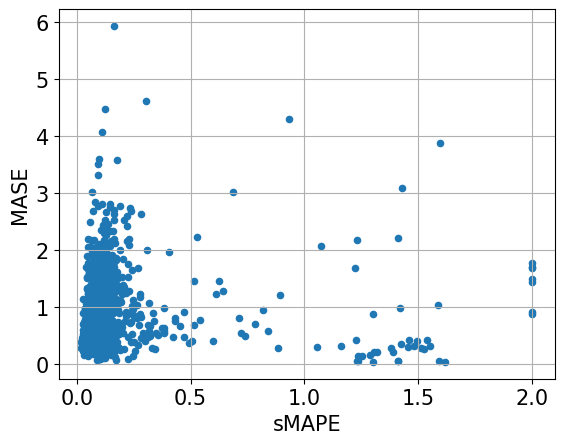

In [61]:
ts_metrics.plot(x='sMAPE', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()

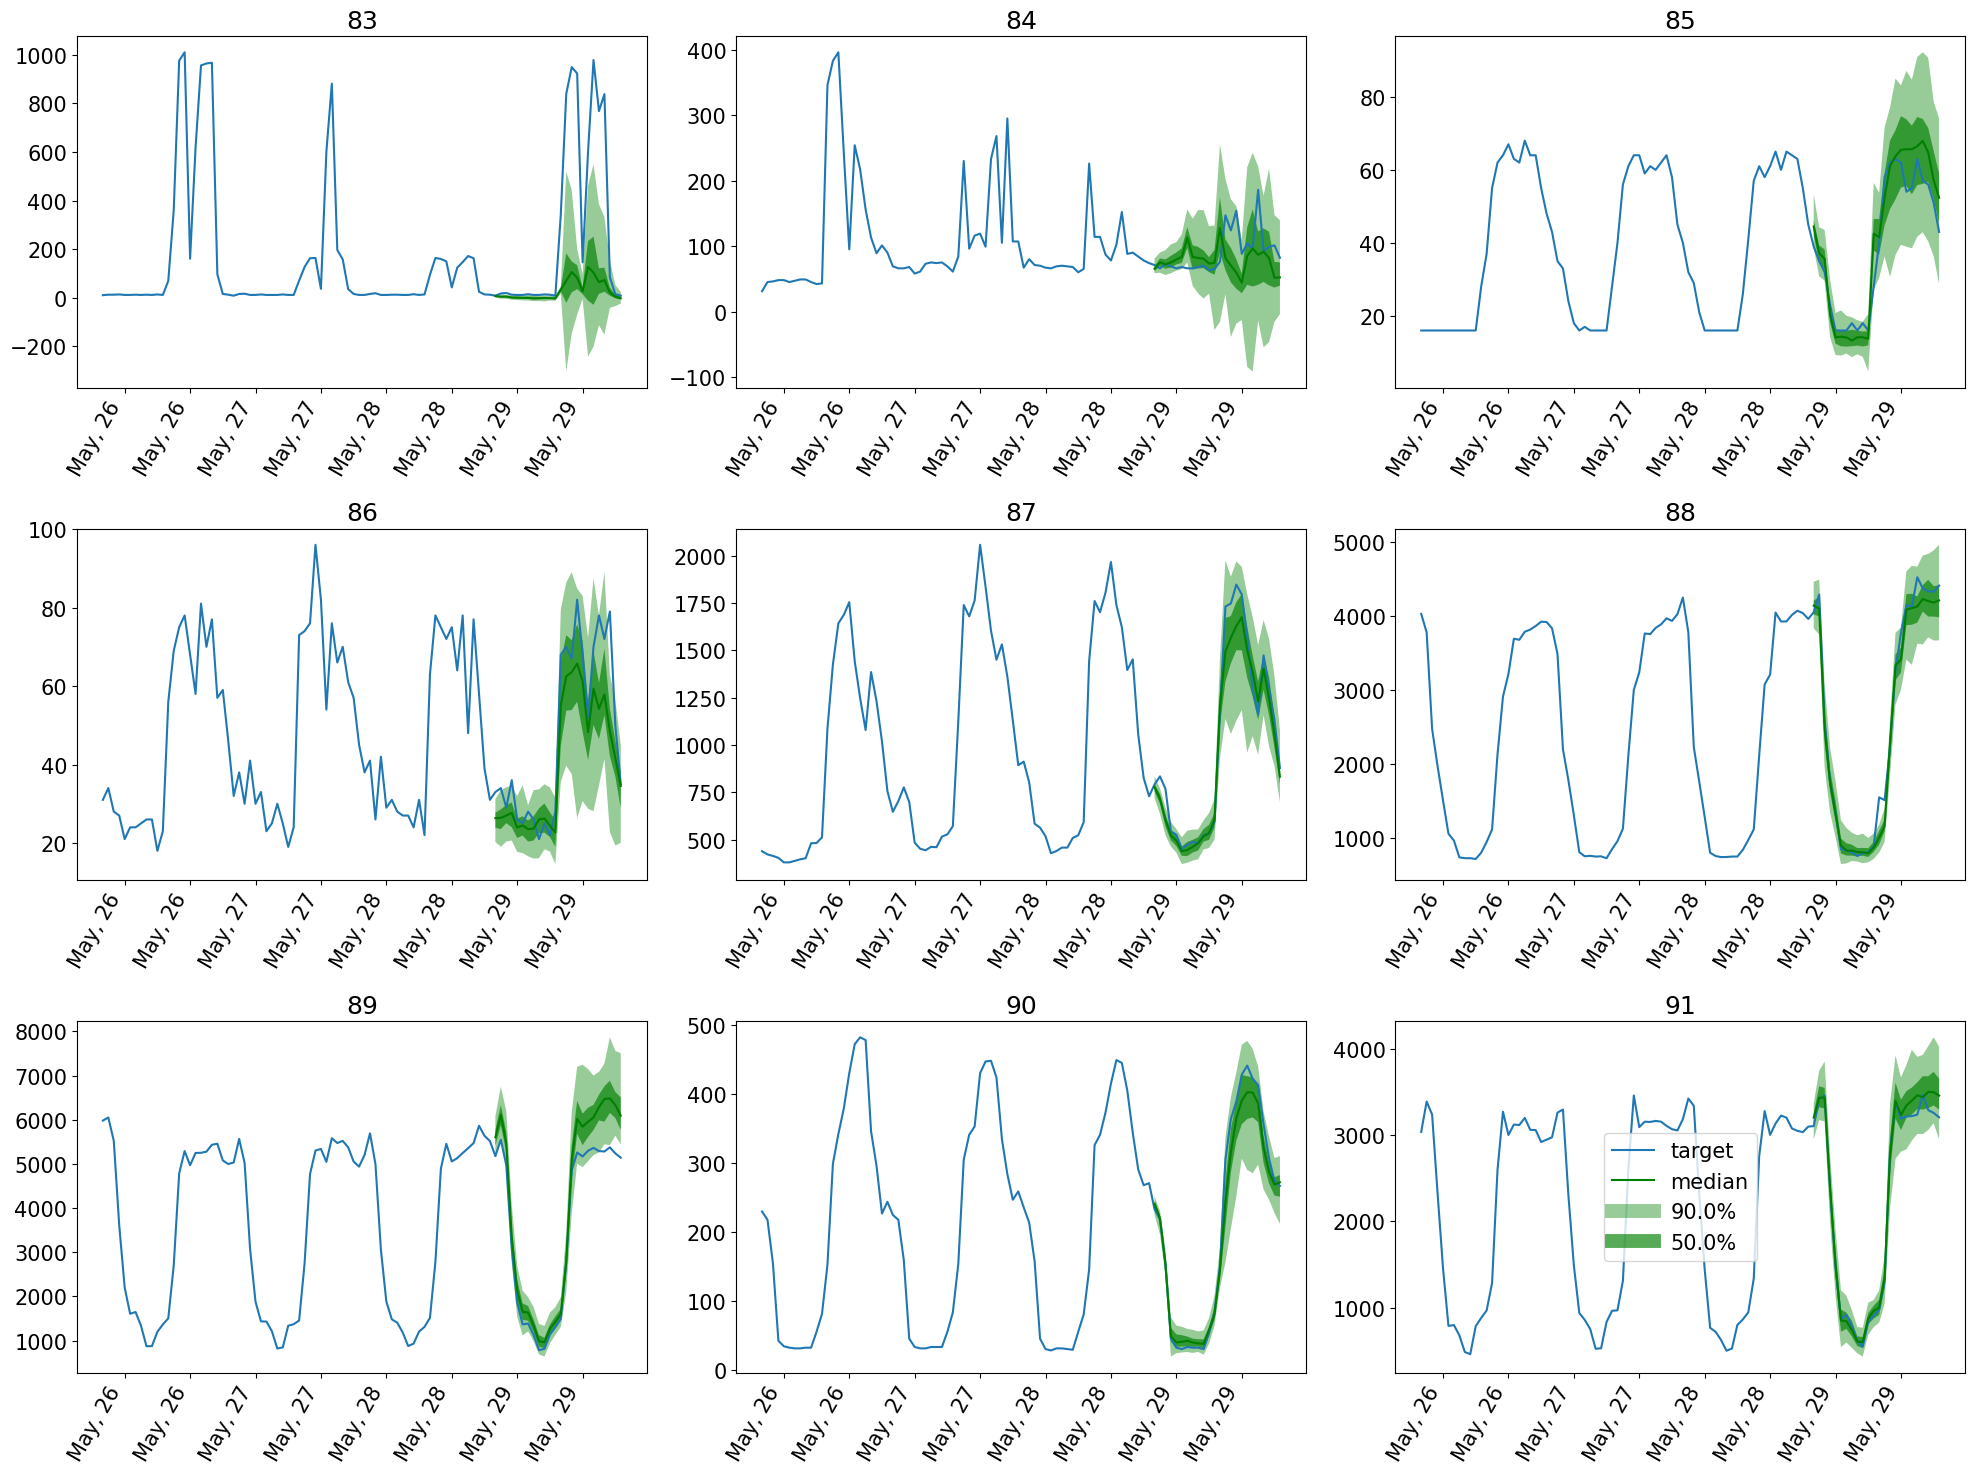

In [62]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 725, 725+9):
    ax = plt.subplot(3, 3, idx+1-725)

    plt.plot(ts[-4 * dataset.metadata.prediction_length:].to_timestamp(), label="target")
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    plt.title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [63]:
ts_metrics[ts_metrics.MASE > 4]

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,ND,...,QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.6],Coverage[0.6],QuantileLoss[0.7],Coverage[0.7],QuantileLoss[0.8],Coverage[0.8],QuantileLoss[0.9],Coverage[0.9]
1076,113,3.053687e+05,12450.291992,18216.0,759.000000,120.439408,4.307246,0.614250,0.931510,0.683481,...,12450.292526,0.000000,13177.016180,0.000000,12789.777866,0.000000,10641.036835,0.083333,6558.660745,0.291667
1403,119,1.954245e+06,32692.917969,251293.0,10470.541667,303.902207,4.482379,0.130574,0.122102,0.130099,...,32692.916992,1.000000,29295.462500,1.000000,24667.969336,1.000000,18827.864844,1.000000,10938.935937,1.000000
1724,119,1.915683e+06,29709.148438,256180.0,10674.166667,304.016272,4.071760,0.116813,0.109133,0.115970,...,29709.149414,1.000000,26672.484375,1.000000,23056.021289,1.000000,17601.454297,1.000000,10657.806055,1.000000
1892,287,5.136151e+04,3327.928955,8619.0,359.125000,30.022044,4.618730,0.252201,0.305402,0.386115,...,3327.928909,0.375000,3544.181610,0.541667,3659.582156,0.666667,3709.785284,0.666667,3029.551833,0.666667
2040,114,1.077192e+02,171.265594,1033.0,43.041667,1.201569,5.938958,0.141269,0.164521,0.165794,...,171.265591,0.041667,194.190707,0.208333,213.946319,0.291667,223.336472,0.375000,227.368535,0.541667
